# Urban Ministries of Durham

The make file makes use of the **tax.py** and **patientsdata.py** python 3 scripts to create the report. This Juputer Notebook illustrates what those python scripts do when creating the data. 

This Jupyter notebook is divided into two parts. *Part 1*, conducts the fraud analysis and *Part 2* identifies individuals who got a new disability while staying at the Urban Ministries of Durham. 

## Part 1 - Fraud Analysis

### I. Reading Data and Packages

In [1]:
# Importing packages and data
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm
# import sys
# import math

# Importing data and subsetting to only include those years with a positive gain in when reporting taxes 
df = pd.read_csv(r'../data/IRS.csv')
df = df[df.Net >= 0]
data = df['Net']
# 12 observations

### II. Extracting first digit of every number

On this code-chunck we will extract the first digit of each number and compare it with the Benford distribution. Any deviations from the theoretical distributions shouls indicate dishonest reporting of income taxes.

In [2]:
# Counting the first digit
def count_first_digit(data_str):
    mask=df[data_str]>1.
    data=list(df[mask][data_str])
    for i in range(len(data)):
        while data[i]>10:
            data[i]=data[i]/10
    first_digits=[int(x) for x in sorted(data)]
    unique=(set(first_digits))#a list with unique values of first_digit list
    data_count=[]
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    total_count=sum(data_count)
    data_percentage=[(i/total_count)*100 for i in data_count]
    return  total_count,data_count, data_percentage

total_count, data_count_pre, data_percentage_pre = count_first_digit("Net")

# In this case data_count_pre and data_percentage_pre have the format of [1,3,4,5,6,8]. 
# Need to add zeros for 2, 7, 9 
data_count = []
data_percentage = []
numbers = []
j = 0
for i in range(1,10):
    numbers.append(i)
    if i in (2,7,9):
        data_count.append(0)
        data_percentage.append(0)
    else:
        data_count.append(data_count_pre[j])
        data_percentage.append(data_percentage_pre[j])
        j = j+1
            
            
# Benford's Law percentages for leading digits 1-9
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

# Get the expected number of counts
expected_counts=[round(p * total_count / 100) for p in BENFORD]

### III. Test for fraud

**Large Sample Theory**

When conducting this analysis one assumes that we have a record of a business taxes for many years so it's typical to use a Chi-Square Test to test for differences between the empirical and the theorical distributions. It is recommened for one to have at least 40 observations but in this case we only have 12. The following are the results from the Chi-Square Test.

In [3]:
# Observed vs Expected  
print(chisquare(data_count, expected_counts))

Power_divergenceResult(statistic=9.5, pvalue=0.30188558340263894)


From the Chi-Square Test we can observe that the sampled data does not provide sufficient evidence to reject the null hypothesis that the empirical distribution does not come from the Benford Distribution with a p-value of 0.30. We can conlude, from the large sample test that there is not sufficient evidence to reject the claim that Urban Ministriest of Durham does not engage in dishonest tax-reporting. 

**Small Sample Theory**

To validate results I a small sample permutation test was conducted. The Mann-Whitney test was used to confirm the results from the Chi-Square. The results are as follows,   

In [4]:
# Wilxocon Rank-Sum Test
mannwhitneyu(data_count,expected_counts)

# Export data
data = {'Counts':data_count, 'ExpectedCounts':expected_counts} 
pd.DataFrame(data).to_csv("fraud_chisq.csv") 

From the Mann-Whitney Test we can observe that the sampled data does not provide sufficient evidence to reject the null hypothesis that the empirical distribution does not come from the Benford Distribution with a p-value of 0.23. We can conclude that neither the small sample nor the large sample test show sufficient evidence to reject the claim that Urban Ministriest of Durham does not engage in dishonest tax-reporting. 

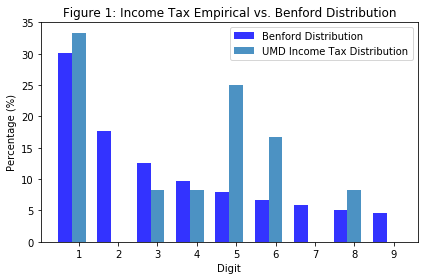

In [5]:
# create plot
n_groups = 9
objects = np.arange(n_groups)
index = np.arange(n_groups)
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(objects, BENFORD, bar_width,
alpha=opacity,
color='b',
label='Benford Distribution')

rects2 = plt.bar(objects + bar_width, data_percentage, bar_width,
alpha=opacity,
label='UMD Income Tax Distribution')

plt.xlabel('Digit')
plt.ylabel('Percentage (%)')
plt.title('Figure 1: Income Tax Empirical vs. Benford Distribution')
plt.xticks(index + bar_width, ('1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()

plt.tight_layout()
plt.show()

**Figure** 1 above represents the empirical distribution of the first digit reported as the net income (revenue minus expenses) in light blue vs the theoretical distribution in dark blue. From visual inspection we can observe that the majority of the revenue values beggin with either a 1 or a 5. According to past IRS analyzes, individuals that engage in dishonest income tax reporting tend to pick values in the middle and not so much from the extremes (eg. 1 or 9), as it happens in this case. From visual inspection we can observe some evidence of potential dishonesty but we would need more more observations to validate results.

In [6]:
# Save data and export to recreate plot in R-Studio
out_tax = pd.DataFrame(columns=['Number', 'Empirical Percentage', 'Benford Distribution'])
out_tax['Number'] = numbers
out_tax['Empirical Percentage'] = data_percentage
out_tax['Benford Percentage'] = BENFORD

out_tax = pd.melt(out_tax, id_vars =['Number'], value_vars =['Empirical Percentage', 'Benford Percentage']) 

# Exporting data to folder data under projects
out_tax.to_csv('tax_data_graph.csv')

## Part 2: Disability Analysis

In this section we are interested in identifying those homeless who got a disability while staying at the Urban Ministries of Durham. Characteristics of interest are socio-demographics and length of stay. 

In [7]:
# Import Data
my_client = pd.read_csv("https://raw.githubusercontent.com/biodatascience/datasci611/gh-pages/data/project2_2019/CLIENT_191102.tsv", sep = '\t')[['Client ID', 'Client Age at Entry', 'Client Age at Exit', 'Client Gender', 'Client Primary Race', 'Client Ethnicity']]
my_disability_entry = pd.read_csv("https://raw.githubusercontent.com/biodatascience/datasci611/gh-pages/data/project2_2019/DISABILITY_ENTRY_191102.tsv", sep = '\t')[['Client ID','Disability Determination (Entry)', 'Disability Type (Entry)']]
my_disability_exit = pd.read_csv("https://raw.githubusercontent.com/biodatascience/datasci611/gh-pages/data/project2_2019/DISABILITY_EXIT_191102.tsv", sep = '\t')[['Client ID','Disability Determination (Exit)', 'Disability Type (Exit)']]

In [8]:
# Rename and merge all datasets
my_disability_entry.rename(columns = {'Disability Type (Entry)':'Disability Type'}, inplace = True)
my_disability_exit.rename(columns = {'Disability Type (Exit)':'Disability Type'}, inplace = True)

# Merge data by client ID
my_disability = pd.merge(my_disability_entry, my_disability_exit, on=['Disability Type','Client ID'], how = 'right')
my_disability.drop_duplicates(keep=False,inplace=True)

# Flag those patients who got a disability while at the UMD
my_disability["GotDisability"] = 0
my_disability.loc[(my_disability['Disability Determination (Entry)'] == 'No (HUD)') &
                            (my_disability['Disability Determination (Exit)'] == 'Yes (HUD)'), 'GotDisability'] = 1

### Statistical Analysis

**Fitting Logistic Regression**

In [9]:
# Merge and remove the (HUD)
my_patients = pd.merge(my_disability, my_client, on = 'Client ID', how = 'left')
my_patients.replace(regex=True,inplace=True,to_replace="(HUD)",value=r'')
my_patients.replace(regex=True,inplace=True,to_replace=r"\(.*\)",value=r'')

# Indicator for age group
my_patients.loc[(my_patients['Client Age at Exit'] < 25), 'Age_Cat'] = '<25'
my_patients.loc[(my_patients['Client Age at Exit'] < 35) & 
                (my_patients['Client Age at Exit'] >= 25), 'Age_Cat'] = '25-34'
my_patients.loc[(my_patients['Client Age at Exit'] < 45) & 
                (my_patients['Client Age at Exit'] >= 35), 'Age_Cat'] = '35-44'
my_patients.loc[(my_patients['Client Age at Exit'] < 55) & 
                (my_patients['Client Age at Exit'] >= 45), 'Age_Cat'] = '45-54'
my_patients.loc[(my_patients['Client Age at Exit'] < 65) & 
                (my_patients['Client Age at Exit'] >= 55), 'Age_Cat'] = '55-64'
my_patients.loc[(my_patients['Client Age at Exit'] >= 65), 'Age_Cat'] = '>64'

# Grouping Unkown Races
my_patients['Client Primary Race'].replace(regex=True,inplace=True,to_replace="Client refused",value=r'Unknown')
my_patients['Client Primary Race'].replace(regex=True,inplace=True,to_replace="Data not collected",value=r'Unknown')
my_patients['Client Primary Race'].replace(regex=True,inplace=True,to_replace="Asian",value=r'Other')
my_patients['Client Primary Race'].replace(regex=True,inplace=True,to_replace="Native Hawaiian or Other Pacific Islander",value=r'Other')


# Rename and create dummy variables
my_patients.rename(columns = {'Client Primary Race':'Race'}, inplace = True)
my_patients.rename(columns = {'Client Gender':'Gender'}, inplace = True)
dummy = pd.get_dummies(my_patients[['Age_Cat', 'Gender','Race','GotDisability']])      

# Assigning predictors 
y = dummy['GotDisability']
X = dummy.drop(columns = ['GotDisability', 'Age_Cat_<25','Gender_Male'])
X = X.iloc[:, :-1]

# Get Parameter Estimates
logit_model=sm.Logit(y,X)
result=logit_model.fit(method = 'lbfgs', fit_intercept=True)

text = result.summary().as_text()
print(result.summary())

# Saving output
with open('logisticoutput.txt', 'w') as fh:
    fh.write(text)

                           Logit Regression Results                           
Dep. Variable:          GotDisability   No. Observations:                10244
Model:                          Logit   Df Residuals:                    10233
Method:                           MLE   Df Model:                           10
Date:                Wed, 27 Nov 2019   Pseudo R-squ.:                 -0.5950
Time:                        12:18:45   Log-Likelihood:                -399.71
converged:                       True   LL-Null:                       -250.61
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Age_Cat_25-34                             -5.5843      0.713     -7.837      0.000      -6.981      -4.188
Age_Cat_35-44                             -5.60

The summary statistics for the coefficients are as follows:

**Model Diagnostics**

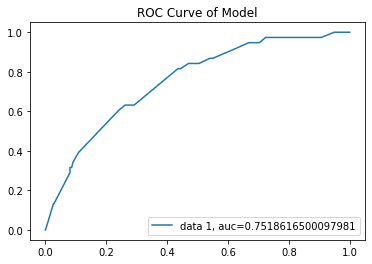

In [10]:
# Calculate AUC
logit_model=LogisticRegression(solver='lbfgs', fit_intercept=True)
logit_model.fit(X,y)

y_pred_proba = logit_model.predict_proba(X)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve of Model')
plt.show()

*Saving output*

In [12]:
#Save data to create plots

# Demographics graph
my_patients[my_patients.GotDisability == 1].to_csv('patients_data_graph.csv')

# Disability Tabulation
mysummary = my_patients[my_patients.GotDisability == 1].groupby(['Gender', 'Disability Type']).count()[['Client ID']]
mysummary.rename(columns = {'Client ID':'N'}, inplace = True)
mysummary.to_csv('counts.csv')

# Logistic Regression Data
my_patients.to_csv('logistic_data.csv')

                                     N
Gender Disability Type                
Female Both Alcohol and Drug Abuse   1
       Chronic Health Condition      3
       HIV/AIDS                      1
       Mental Health Problem         8
       Physical                      5
Male   Alcohol Abuse                 2
       Both Alcohol and Drug Abuse   2
       Chronic Health Condition      4
       Developmental                 1
       Drug Abuse                    2
       HIV/AIDS                      1
       Mental Health Problem         6
       Physical                      2
